In [1]:
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tqdm import tqdm
import tensorflow_datasets.public_api as tfds
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection, preprocessing
np.random.seed(597)
tf.random.set_seed(597)
tf.config.list_physical_devices('GPU')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0
# Split validation set
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=10000, random_state=597)
X_train = tf.reshape(X_train, (50000, 784))
X_val = tf.reshape(X_val, (10000, 784))
X_test = tf.reshape(X_test, (10000, 784))
assert X_train.shape == (50000, 784)
assert X_val.shape == (10000, 784)
assert X_test.shape == (10000, 784)
assert y_train.shape == (50000,)
assert y_val.shape == (10000,)
assert y_test.shape == (10000,)

4


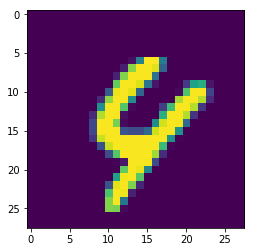

In [3]:
# Take a look at the first digit
print(y_train[0])
plt.imshow(tf.reshape(X_train[0], (28, 28)))

In [4]:
size_input = 784
size_hidden1 = 300
size_hidden2 = 100
size_output = 10
number_of_train_examples = 50000
number_of_val_examples = 10000
number_of_test_examples = 10000

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(20)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(10)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(10)

In [5]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_output, lr=1e-3, 
               optimizer=tf.keras.optimizers.Adam, reg=None, dropout=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of hidden layer1
    size_hidden2: int, size of hidden layer2
    size_output: int, size of output layer
    lr: float, learning rate for optimizer
    reg: list, penalty. e.g. ['l1']
    dropout: float, dropout rate
    optimizer: class, keras inbuild optimizer to be used
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.lr, self.reg, self.dropout, self.optimizer =\
    size_input, size_hidden1, size_hidden2, size_output, lr, reg, dropout, optimizer
    
    # Initialize weights between input layer and hidden layer 1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev = 0.1))
    # Initialize biases for hidden layer 1
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
    # Initialize weights between hidden layer 1 and hidden layer 2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev = 0.1))
    # Initialize biases for hidden layer 2
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
     # Initialize weights between hidden layer 2 and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output], stddev = 0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    Always use gpu
    """
    with tf.device('gpu:0'):
        self.y = self.compute_output(X)
        
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.int32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    # Use softmax categorical cross entropy for classification task
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
    if self.reg != None:
        if self.reg == ['l1']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]))
        elif self.reg == ['l2']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.nn.l2_loss(var) for var in self.variables]))
        elif self.reg == ['l1', 'l2']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in self.variables])) +\
                          1e-5*(tf.reduce_sum([tf.nn.l2_loss(var) for var in self.variables]))
        else:
            assert 1==0, "The parameters of regularization is unknown, please use ['l1'] or ['l1', 'l2']"
    # Add l1 reg
    return  loss 
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = self.optimizer(learning_rate=self.lr)
    with tf.GradientTape() as tape:
        predicted = self.forward(X_train)
        current_loss = self.loss(predicted, y_train) 
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Compute values in hidden layer 1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Add dropout
    if self.dropout != None:     
        hhat1 = tf.nn.dropout(hhat1, rate = self.dropout, seed = 597)
    # Compute values in hidden layer 2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Add dropout
    if self.dropout != None:     
        hhat2 = tf.nn.dropout(hhat2, rate = self.dropout, seed = 597)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # softmax is applied in the calculation of cross entropy
    return output

In [8]:
# Define class to build mlp model with customized optimizer
class MLP2(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_output, lr=1e-3, 
               optimizer=tf.keras.optimizers.Adam, reg=None, dropout=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of hidden layer1
    size_hidden2: int, size of hidden layer2
    size_output: int, size of output layer
    lr: float, learning rate for optimizer
    reg: list, penalty. e.g. ['l1']
    dropout: float, dropout rate
    normal: bool, whether normalize the data
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.lr, self.reg, self.dropout =\
    size_input, size_hidden1, size_hidden2, size_output, lr, reg, dropout
    
    # Initialize weights between input layer and hidden layer 1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev = 0.1))
    # Initialize biases for hidden layer 1
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
    # Initialize weights between hidden layer 1 and hidden layer 2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev = 0.1))
    # Initialize biases for hidden layer 2
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
     # Initialize weights between hidden layer 2 and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output], stddev = 0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    # Initialize optimizer parameters
    self.t = 0                       # Initialize timestep
    self.m = [0]*len(self.variables) # Initialize 1st moment vector
    self.v = [0]*len(self.variables) # Initialize 2nd moment vector
    self.u = [0]*len(self.variables) # Initialize 3rd moment vector
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    Always use gpu
    """
    with tf.device('/gpu:0'):
        self.y = self.compute_output(X)
        
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.int32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    # Use softmax categorical cross entropy for classification task
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true_tf, y_pred_tf)
    # Add penalty
    if self.reg != None:
        if self.reg == ['l1']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]))
        elif self.reg == ['l2']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.nn.l2_loss(var) for var in self.variables]))
        elif self.reg == ['l1', 'l2']:
            loss = loss + 1e-5*(tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in self.variables])) +\
                          1e-5*(tf.reduce_sum([tf.nn.l2_loss(var) for var in self.variables]))
        else:
            assert 1==0, "The parameters of regularization is unknown, please use ['l1'] or ['l1', 'l2']"
    return  loss 
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    with tf.GradientTape() as tape:
        predicted = self.forward(X_train)
        current_loss = self.loss(predicted, y_train) 
        
    # Get gradients w.r.t. stochastic objective at timestep t
    grads = tape.gradient(current_loss, self.variables)
    
    # Exponential decay rates for the moment estimates
    beta1 = 0.9
    beta2 = 0.999
    beta3 = 0.999987
    
    epsilon = 1e-8
    epsilon2 = 1e-6
    
    dws = grads
    
    # Update biased moment estimates
    self.m = [beta1*a_i + (1-beta1)*b_i for a_i, b_i in zip(self.m, dws)]
    dws2 = [i*i for i in dws]
    self.v = [beta2*a_i + (1-beta2)*b_i for a_i, b_i in zip(self.v, dws2)]
    dws3 = [i*i*i for i in dws]
    self.u = [beta3*a_i + (1-beta3)*b_i for a_i, b_i in zip(self.u, dws3)]
    
    # Compute bias-corrected moment estimates
    m_hat = [i/(1-(beta1**self.t if self.t > 0 else 0)) for i in self.m] # let m_hat = m when t = 0
    v_hat = [i/(1-(beta2**self.t if self.t > 0 else 0)) for i in self.v]
    u_hat = [i/(1-(beta3**self.t if self.t > 0 else 0)) for i in self.u]
    
    # Update parameters
    Wt = [d_i - self.lr * a_i/(tf.math.sqrt(tf.math.abs(b_i)) + tf.math.sign(c_i)*tf.math.pow(tf.math.abs(c_i), 1/3)*epsilon + epsilon2) 
          for a_i, b_i, c_i, d_i in zip(m_hat, v_hat, u_hat, self.variables)]
    
    W = self.variables[0]
    W.assign(Wt[0])
    W1 = self.variables[1]
    W1.assign(Wt[1])
    W2 = self.variables[2]
    W2.assign(Wt[2])
    B = self.variables[3]
    B.assign(Wt[3])
    B1 = self.variables[4]
    B1.assign(Wt[4])
    B2 = self.variables[5]
    B2.assign(Wt[5])
      
    self.t = self.t + 1
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Compute values in hidden layer 1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Add dropout
    if self.dropout != None:     
        hhat1 = tf.nn.dropout(hhat1, rate = self.dropout, seed = 597)
    # Compute values in hidden layer 2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Add dropout
    if self.dropout != None:     
        hhat2 = tf.nn.dropout(hhat2, rate = self.dropout, seed = 597)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    # softmax is applied in the calculation of cross entropy
    return output

In [9]:
# Validation
# Set number of epochs
NUM_EPOCHS = 20
# Set random seed
np.random.seed(597)
tf.random.set_seed(597)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=10000, random_state=597)
X_train = tf.reshape(X_train, (50000, 784))
X_val = tf.reshape(X_val, (10000, 784))
X_test = tf.reshape(X_test, (10000, 784))
# Initialize model using GPU
mlp = MLP(size_input, size_hidden1, size_hidden2, size_output, lr=0.002, optimizer=tf.keras.optimizers.RMSprop, reg=['l2'])

time_start = time.time()
training_df = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
for epoch in range(NUM_EPOCHS):
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    acc = []
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(597)).batch(100)
    for inputs, outputs in tqdm(train_ds):
        preds = mlp.forward(inputs)
        loss_total = loss_total + mlp.loss(preds, outputs)
        lt = lt + mlp.loss(preds, outputs)
        acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
        mlp.backward(inputs, outputs)
    avg_loss = np.sum(loss_total) / X_train.shape[0]
    avg_acc = np.mean(acc)
    training_df.loc[epoch, ['epoch', 'train_loss', 'train_accuracy']] = [epoch + 1, avg_loss, avg_acc]
    print('Number of Epoch = {} - Average cross entropy:= {:.4f}'.format(epoch + 1, avg_loss),
          '\n                    - Average accuracy:= {:.4f}'.format(avg_acc))
    # validation for each epoch
    val_loss_total = tf.Variable(0, dtype=tf.float32)
    val_acc = []
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(25, seed=epoch*(597)).batch(20)
    for inputs, outputs in val_ds:
        preds = mlp.forward(inputs)
        val_loss_total = val_loss_total + mlp.loss(preds, outputs)
        val_acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
    val_avg_loss = np.sum(val_loss_total) / X_val.shape[0]
    val_avg_acc = np.mean(val_acc)
    training_df.loc[epoch, ['val_loss', 'val_accuracy']] = [val_avg_loss, val_avg_acc]

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

100%|██████████| 500/500 [00:11<00:00, 42.67it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0067 
                    - Average accuracy:= 0.8637


100%|██████████| 500/500 [00:11<00:00, 42.50it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0062 
                    - Average accuracy:= 0.9008


100%|██████████| 500/500 [00:11<00:00, 42.15it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0059 
                    - Average accuracy:= 0.9072


100%|██████████| 500/500 [00:11<00:00, 42.88it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0049 
                    - Average accuracy:= 0.9178


100%|██████████| 500/500 [00:11<00:00, 43.73it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0051 
                    - Average accuracy:= 0.9180


100%|██████████| 500/500 [00:11<00:00, 43.04it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0050 
                    - Average accuracy:= 0.9197


100%|██████████| 500/500 [00:11<00:00, 42.98it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0054 
                    - Average accuracy:= 0.9200


100%|██████████| 500/500 [00:11<00:00, 41.78it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0052 
                    - Average accuracy:= 0.9234


100%|██████████| 500/500 [00:11<00:00, 43.65it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0049 
                    - Average accuracy:= 0.9242


100%|██████████| 500/500 [00:11<00:00, 43.44it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0050 
                    - Average accuracy:= 0.9259


100%|██████████| 500/500 [00:11<00:00, 41.82it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0048 
                    - Average accuracy:= 0.9253


100%|██████████| 500/500 [00:11<00:00, 42.95it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0049 
                    - Average accuracy:= 0.9260


100%|██████████| 500/500 [00:11<00:00, 42.06it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0049 
                    - Average accuracy:= 0.9274


100%|██████████| 500/500 [00:12<00:00, 40.28it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0051 
                    - Average accuracy:= 0.9254


100%|██████████| 500/500 [00:12<00:00, 40.88it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0049 
                    - Average accuracy:= 0.9277


100%|██████████| 500/500 [00:12<00:00, 41.64it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0045 
                    - Average accuracy:= 0.9290


100%|██████████| 500/500 [00:11<00:00, 41.85it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0048 
                    - Average accuracy:= 0.9268


100%|██████████| 500/500 [00:12<00:00, 41.59it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0046 
                    - Average accuracy:= 0.9285


100%|██████████| 500/500 [00:12<00:00, 39.30it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0045 
                    - Average accuracy:= 0.9297


100%|██████████| 500/500 [00:13<00:00, 38.45it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0046 
                    - Average accuracy:= 0.9290

Total time taken (in seconds): 267.12


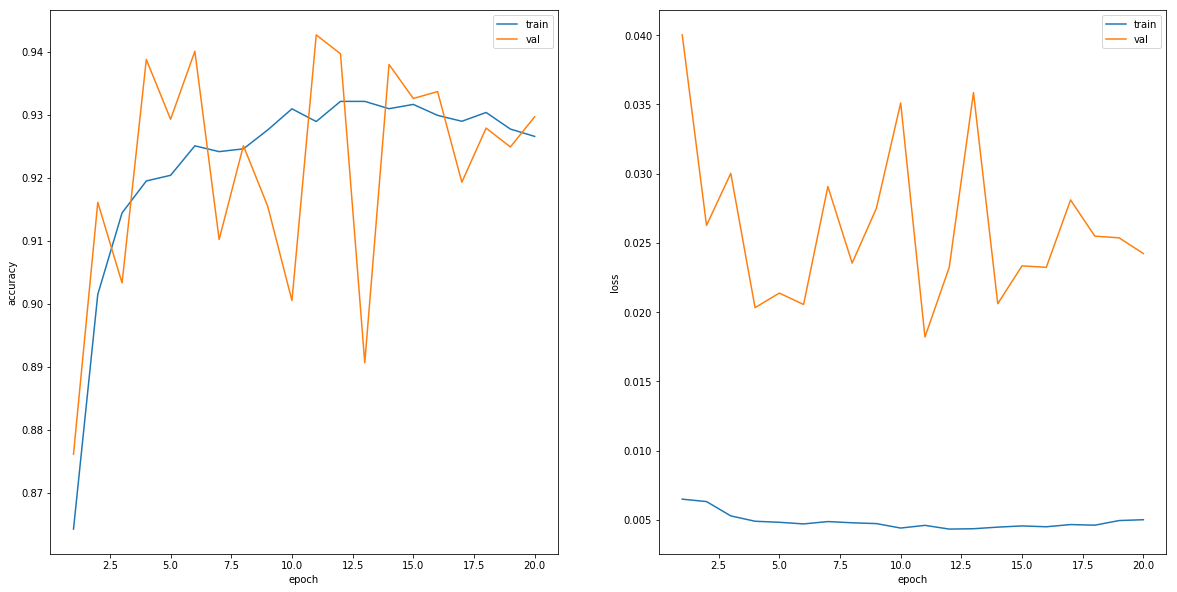

In [377]:
# Plot train validation error
f = plt.figure(figsize=(20, 10))
ax1 = f.add_subplot(121, xlabel = 'epoch', ylabel = 'accuracy')
ax2 = f.add_subplot(122, xlabel = 'epoch', ylabel = 'loss')
ax1.plot(training_df['epoch'], training_df['train_accuracy'], label = 'train')
ax1.plot(training_df['epoch'], training_df['val_accuracy'], label = 'val')
ax1.legend()
ax2.plot(training_df['epoch'], training_df['train_loss'], label = 'train')
ax2.plot(training_df['epoch'], training_df['val_loss'], label = 'val')
ax2.legend()

In [346]:
# Validation
val_loss_total = tf.Variable(0, dtype=tf.float32)
val_acc = []
for inputs, outputs in val_ds:
    preds = mlp.forward(inputs)
    val_loss_total = val_loss_total + mlp.loss(preds, outputs)
    val_acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
val_avg_loss = np.sum(val_loss_total) / X_val.shape[0]
val_avg_acc = np.mean(val_acc)
print('Validation cross entropy: {:.4f}'.format(val_avg_loss),
      '\nTest accuracy:= {:.4f}'.format(val_avg_acc))

Validation cross entropy: 0.7858 
Test accuracy:= 0.7862


In [367]:
# Train with all training data
def train(trail):
    # Set number of epochs
    NUM_EPOCHS = 20
    # Set random seed
    np.random.seed(trail*597)
    tf.random.set_seed(trail*597)
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train/255.0
    X_test = X_test/255.0
    X_train = tf.reshape(X_train, (60000, 784))
    X_test = tf.reshape(X_test, (10000, 784))
    # Initialize model using GPU
    mlp = MLP(size_input, size_hidden1, size_hidden2, size_output, lr=0.001, optimizer=tf.keras.optimizers.RMSprop)

    time_start = time.time()
    training_df = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
    for epoch in range(NUM_EPOCHS):
        loss_total = tf.zeros([1,1], dtype=tf.float32)
        lt = 0
        acc = []
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(trail*597)).batch(100)
        for inputs, outputs in tqdm(train_ds):
            preds = mlp.forward(inputs)
            loss_total = loss_total + mlp.loss(preds, outputs)
            lt = lt + mlp.loss(preds, outputs)
            acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
            mlp.backward(inputs, outputs)
        avg_loss = np.sum(loss_total) / X_train.shape[0]
        avg_acc = np.mean(acc)
        training_df.loc[epoch, ['epoch', 'train_loss', 'train_accuracy']] = [epoch + 1, avg_loss, avg_acc]
        print('Number of Epoch = {} - Average cross entropy:= {:.4f}'.format(epoch + 1, avg_loss),
              '\n                    - Average accuracy:= {:.4f}'.format(avg_acc))

    time_taken = time.time() - time_start

    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
    
    return mlp, training_df

In [368]:
# Run the whole process 10 times
time_start = time.time()
testing_df = pd.DataFrame(columns = ['trail', 'accuracy', 'loss'])
for trail in range(10):
    print('trail: ', trail+1)
    mlp, training_df = train(trail+1)
    test_loss_total = tf.Variable(0, dtype=tf.float32)
    test_acc = []
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(25, seed=trail*(597)).batch(20)
    for inputs, outputs in test_ds:
        preds = mlp.forward(inputs)
        test_loss_total = test_loss_total + mlp.loss(preds, outputs)
        test_acc.append(tf.keras.metrics.sparse_categorical_accuracy(outputs, preds))
    test_avg_loss = np.sum(test_loss_total) / X_test.shape[0]
    test_avg_acc = np.mean(test_acc)
    testing_df.loc[trail] = [trail+1, test_avg_acc, test_avg_loss]
    print('Test cross entropy: {:.4f}'.format(test_avg_loss),
          '\nTest accuracy:= {:.4f}'.format(test_avg_acc))
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

trail:  1


100%|██████████| 600/600 [00:12<00:00, 49.36it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9135


100%|██████████| 600/600 [00:12<00:00, 48.17it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9550


100%|██████████| 600/600 [00:12<00:00, 48.98it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9637


100%|██████████| 600/600 [00:11<00:00, 50.63it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9685


100%|██████████| 600/600 [00:11<00:00, 51.79it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0033 
                    - Average accuracy:= 0.9743


100%|██████████| 600/600 [00:12<00:00, 49.15it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0033 
                    - Average accuracy:= 0.9771


100%|██████████| 600/600 [00:12<00:00, 47.71it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0027 
                    - Average accuracy:= 0.9808


100%|██████████| 600/600 [00:11<00:00, 50.57it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0025 
                    - Average accuracy:= 0.9819


100%|██████████| 600/600 [00:11<00:00, 50.39it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0025 
                    - Average accuracy:= 0.9831


100%|██████████| 600/600 [00:12<00:00, 49.16it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0021 
                    - Average accuracy:= 0.9855


100%|██████████| 600/600 [00:14<00:00, 42.11it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9865


100%|██████████| 600/600 [00:12<00:00, 48.18it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9877


100%|██████████| 600/600 [00:11<00:00, 50.98it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9890


100%|██████████| 600/600 [00:12<00:00, 49.82it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0016 
                    - Average accuracy:= 0.9894


100%|██████████| 600/600 [00:11<00:00, 51.12it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9905


100%|██████████| 600/600 [00:11<00:00, 50.97it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9911


100%|██████████| 600/600 [00:11<00:00, 51.22it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9918


100%|██████████| 600/600 [00:11<00:00, 51.02it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9923


100%|██████████| 600/600 [00:11<00:00, 51.19it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9925


100%|██████████| 600/600 [00:11<00:00, 51.02it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9935

Total time taken (in seconds): 398.05
Test cross entropy: 0.0344 
Test accuracy:= 0.9736
trail:  2


100%|██████████| 600/600 [00:11<00:00, 50.54it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9139


100%|██████████| 600/600 [00:11<00:00, 50.80it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0040 
                    - Average accuracy:= 0.9526


100%|██████████| 600/600 [00:11<00:00, 50.85it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9630


100%|██████████| 600/600 [00:11<00:00, 50.69it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9691


100%|██████████| 600/600 [00:11<00:00, 50.13it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0035 
                    - Average accuracy:= 0.9743


100%|██████████| 600/600 [00:12<00:00, 47.46it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0032 
                    - Average accuracy:= 0.9767


100%|██████████| 600/600 [00:11<00:00, 50.20it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0028 
                    - Average accuracy:= 0.9800


100%|██████████| 600/600 [00:11<00:00, 50.62it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0025 
                    - Average accuracy:= 0.9826


100%|██████████| 600/600 [00:12<00:00, 47.99it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0024 
                    - Average accuracy:= 0.9837


100%|██████████| 600/600 [00:11<00:00, 50.64it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0020 
                    - Average accuracy:= 0.9853


100%|██████████| 600/600 [00:11<00:00, 50.67it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0020 
                    - Average accuracy:= 0.9862


100%|██████████| 600/600 [00:11<00:00, 50.70it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9876


100%|██████████| 600/600 [00:11<00:00, 50.04it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9887


100%|██████████| 600/600 [00:11<00:00, 50.34it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9896


100%|██████████| 600/600 [00:11<00:00, 50.71it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9905


100%|██████████| 600/600 [00:11<00:00, 50.75it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9911


100%|██████████| 600/600 [00:11<00:00, 50.41it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9911


100%|██████████| 600/600 [00:11<00:00, 50.54it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9914


100%|██████████| 600/600 [00:11<00:00, 50.39it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9921


100%|██████████| 600/600 [00:11<00:00, 50.61it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9932

Total time taken (in seconds): 394.65
Test cross entropy: 0.0298 
Test accuracy:= 0.9761
trail:  3


100%|██████████| 600/600 [00:11<00:00, 50.89it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9148


100%|██████████| 600/600 [00:11<00:00, 50.22it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0042 
                    - Average accuracy:= 0.9529


100%|██████████| 600/600 [00:11<00:00, 50.80it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9642


100%|██████████| 600/600 [00:11<00:00, 50.93it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0036 
                    - Average accuracy:= 0.9700


100%|██████████| 600/600 [00:11<00:00, 50.89it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0034 
                    - Average accuracy:= 0.9737


100%|██████████| 600/600 [00:11<00:00, 50.87it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0031 
                    - Average accuracy:= 0.9779


100%|██████████| 600/600 [00:11<00:00, 51.04it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0029 
                    - Average accuracy:= 0.9801


100%|██████████| 600/600 [00:11<00:00, 50.24it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0025 
                    - Average accuracy:= 0.9826


100%|██████████| 600/600 [00:11<00:00, 51.00it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0021 
                    - Average accuracy:= 0.9851


100%|██████████| 600/600 [00:11<00:00, 50.55it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0021 
                    - Average accuracy:= 0.9856


100%|██████████| 600/600 [00:11<00:00, 51.12it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9869


100%|██████████| 600/600 [00:11<00:00, 51.11it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0018 
                    - Average accuracy:= 0.9875


100%|██████████| 600/600 [00:11<00:00, 50.80it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9886


100%|██████████| 600/600 [00:11<00:00, 50.09it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9894


100%|██████████| 600/600 [00:11<00:00, 50.50it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9906


100%|██████████| 600/600 [00:11<00:00, 50.64it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9906


100%|██████████| 600/600 [00:11<00:00, 50.88it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9915


100%|██████████| 600/600 [00:11<00:00, 51.18it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9923


100%|██████████| 600/600 [00:11<00:00, 50.97it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9927


100%|██████████| 600/600 [00:11<00:00, 50.50it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0008 
                    - Average accuracy:= 0.9930

Total time taken (in seconds): 391.53
Test cross entropy: 0.0360 
Test accuracy:= 0.9711
trail:  4


100%|██████████| 600/600 [00:11<00:00, 50.96it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0037 
                    - Average accuracy:= 0.9160


100%|██████████| 600/600 [00:11<00:00, 51.17it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9551


100%|██████████| 600/600 [00:11<00:00, 51.18it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9634


100%|██████████| 600/600 [00:11<00:00, 51.16it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9695


100%|██████████| 600/600 [00:11<00:00, 50.68it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0035 
                    - Average accuracy:= 0.9730


100%|██████████| 600/600 [00:11<00:00, 50.74it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0031 
                    - Average accuracy:= 0.9773


100%|██████████| 600/600 [00:12<00:00, 49.70it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0027 
                    - Average accuracy:= 0.9797


100%|██████████| 600/600 [00:11<00:00, 50.85it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0027 
                    - Average accuracy:= 0.9807


100%|██████████| 600/600 [00:11<00:00, 50.57it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0025 
                    - Average accuracy:= 0.9829


100%|██████████| 600/600 [00:11<00:00, 50.88it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0023 
                    - Average accuracy:= 0.9850


100%|██████████| 600/600 [00:11<00:00, 50.79it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9863


100%|██████████| 600/600 [00:11<00:00, 50.81it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9876


100%|██████████| 600/600 [00:11<00:00, 51.12it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9888


100%|██████████| 600/600 [00:12<00:00, 49.94it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9898


100%|██████████| 600/600 [00:11<00:00, 51.04it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9903


100%|██████████| 600/600 [00:11<00:00, 51.17it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9904


100%|██████████| 600/600 [00:11<00:00, 50.83it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9917


100%|██████████| 600/600 [00:11<00:00, 50.74it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9928


100%|██████████| 600/600 [00:11<00:00, 50.24it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9930


100%|██████████| 600/600 [00:12<00:00, 48.17it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9926

Total time taken (in seconds): 394.19
Test cross entropy: 0.0408 
Test accuracy:= 0.9677
trail:  5


100%|██████████| 600/600 [00:11<00:00, 51.22it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9136


100%|██████████| 600/600 [00:11<00:00, 51.50it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0042 
                    - Average accuracy:= 0.9526


100%|██████████| 600/600 [00:11<00:00, 51.22it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9628


100%|██████████| 600/600 [00:11<00:00, 51.44it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9688


100%|██████████| 600/600 [00:11<00:00, 51.24it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0032 
                    - Average accuracy:= 0.9750


100%|██████████| 600/600 [00:11<00:00, 50.87it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0028 
                    - Average accuracy:= 0.9785


100%|██████████| 600/600 [00:11<00:00, 51.60it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0028 
                    - Average accuracy:= 0.9791


100%|██████████| 600/600 [00:11<00:00, 50.99it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0025 
                    - Average accuracy:= 0.9816


100%|██████████| 600/600 [00:11<00:00, 51.31it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0023 
                    - Average accuracy:= 0.9837


100%|██████████| 600/600 [00:11<00:00, 51.52it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0020 
                    - Average accuracy:= 0.9853


100%|██████████| 600/600 [00:11<00:00, 51.72it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9863


100%|██████████| 600/600 [00:11<00:00, 51.65it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9875


100%|██████████| 600/600 [00:11<00:00, 51.22it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0016 
                    - Average accuracy:= 0.9882


100%|██████████| 600/600 [00:11<00:00, 50.61it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9891


100%|██████████| 600/600 [00:11<00:00, 51.34it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9897


100%|██████████| 600/600 [00:11<00:00, 50.67it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9911


100%|██████████| 600/600 [00:11<00:00, 51.19it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9914


100%|██████████| 600/600 [00:11<00:00, 50.75it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9922


100%|██████████| 600/600 [00:11<00:00, 51.20it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9928


100%|██████████| 600/600 [00:11<00:00, 51.04it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9932

Total time taken (in seconds): 390.19
Test cross entropy: 0.0271 
Test accuracy:= 0.9770
trail:  6


100%|██████████| 600/600 [00:11<00:00, 51.30it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0037 
                    - Average accuracy:= 0.9151


100%|██████████| 600/600 [00:11<00:00, 51.16it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9528


100%|██████████| 600/600 [00:11<00:00, 50.47it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0042 
                    - Average accuracy:= 0.9629


100%|██████████| 600/600 [00:11<00:00, 51.64it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9689


100%|██████████| 600/600 [00:11<00:00, 51.25it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0034 
                    - Average accuracy:= 0.9743


100%|██████████| 600/600 [00:11<00:00, 50.17it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0031 
                    - Average accuracy:= 0.9771


100%|██████████| 600/600 [00:11<00:00, 50.42it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0027 
                    - Average accuracy:= 0.9802


100%|██████████| 600/600 [00:11<00:00, 51.32it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0024 
                    - Average accuracy:= 0.9820


100%|██████████| 600/600 [00:11<00:00, 51.31it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0024 
                    - Average accuracy:= 0.9833


100%|██████████| 600/600 [00:11<00:00, 51.42it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0021 
                    - Average accuracy:= 0.9848


100%|██████████| 600/600 [00:12<00:00, 47.88it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9869


100%|██████████| 600/600 [00:11<00:00, 50.22it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9883


100%|██████████| 600/600 [00:11<00:00, 51.31it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9892


100%|██████████| 600/600 [00:11<00:00, 51.19it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9892


100%|██████████| 600/600 [00:11<00:00, 50.75it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9904


100%|██████████| 600/600 [00:11<00:00, 50.56it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9909


100%|██████████| 600/600 [00:11<00:00, 50.79it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9921


100%|██████████| 600/600 [00:11<00:00, 50.07it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9920


100%|██████████| 600/600 [00:11<00:00, 51.28it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9921


100%|██████████| 600/600 [00:11<00:00, 50.97it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9932

Total time taken (in seconds): 391.35
Test cross entropy: 0.0279 
Test accuracy:= 0.9748
trail:  7


100%|██████████| 600/600 [00:11<00:00, 51.19it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0040 
                    - Average accuracy:= 0.9126


100%|██████████| 600/600 [00:11<00:00, 51.08it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9540


100%|██████████| 600/600 [00:11<00:00, 51.37it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0042 
                    - Average accuracy:= 0.9632


100%|██████████| 600/600 [00:11<00:00, 50.90it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9692


100%|██████████| 600/600 [00:11<00:00, 51.80it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0034 
                    - Average accuracy:= 0.9741


100%|██████████| 600/600 [00:11<00:00, 51.72it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0031 
                    - Average accuracy:= 0.9773


100%|██████████| 600/600 [00:11<00:00, 50.43it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0029 
                    - Average accuracy:= 0.9792


100%|██████████| 600/600 [00:11<00:00, 50.76it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0026 
                    - Average accuracy:= 0.9819


100%|██████████| 600/600 [00:11<00:00, 51.21it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0024 
                    - Average accuracy:= 0.9832


100%|██████████| 600/600 [00:11<00:00, 50.63it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0021 
                    - Average accuracy:= 0.9855


100%|██████████| 600/600 [00:11<00:00, 51.57it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9873


100%|██████████| 600/600 [00:11<00:00, 51.04it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0016 
                    - Average accuracy:= 0.9882


100%|██████████| 600/600 [00:11<00:00, 51.29it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9892


100%|██████████| 600/600 [00:11<00:00, 51.23it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9907


100%|██████████| 600/600 [00:11<00:00, 51.64it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9906


100%|██████████| 600/600 [00:11<00:00, 51.43it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9911


100%|██████████| 600/600 [00:11<00:00, 50.82it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9920


100%|██████████| 600/600 [00:11<00:00, 50.64it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9926


100%|██████████| 600/600 [00:11<00:00, 51.14it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0008 
                    - Average accuracy:= 0.9931


100%|██████████| 600/600 [00:11<00:00, 51.42it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0008 
                    - Average accuracy:= 0.9940

Total time taken (in seconds): 389.12
Test cross entropy: 0.0331 
Test accuracy:= 0.9722
trail:  8


100%|██████████| 600/600 [00:11<00:00, 51.52it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9149


100%|██████████| 600/600 [00:11<00:00, 51.48it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9533


100%|██████████| 600/600 [00:11<00:00, 51.08it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0042 
                    - Average accuracy:= 0.9615


100%|██████████| 600/600 [00:11<00:00, 50.79it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9695


100%|██████████| 600/600 [00:11<00:00, 51.35it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0035 
                    - Average accuracy:= 0.9745


100%|██████████| 600/600 [00:11<00:00, 51.30it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0031 
                    - Average accuracy:= 0.9772


100%|██████████| 600/600 [00:11<00:00, 51.44it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0028 
                    - Average accuracy:= 0.9797


100%|██████████| 600/600 [00:11<00:00, 51.32it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0026 
                    - Average accuracy:= 0.9821


100%|██████████| 600/600 [00:11<00:00, 51.46it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0023 
                    - Average accuracy:= 0.9837


100%|██████████| 600/600 [00:11<00:00, 51.49it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0021 
                    - Average accuracy:= 0.9850


100%|██████████| 600/600 [00:11<00:00, 50.58it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9869


100%|██████████| 600/600 [00:11<00:00, 51.41it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0018 
                    - Average accuracy:= 0.9872


100%|██████████| 600/600 [00:11<00:00, 51.72it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9884


100%|██████████| 600/600 [00:11<00:00, 51.53it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9899


100%|██████████| 600/600 [00:11<00:00, 51.55it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9904


100%|██████████| 600/600 [00:11<00:00, 51.39it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9914


100%|██████████| 600/600 [00:11<00:00, 51.05it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9925


100%|██████████| 600/600 [00:11<00:00, 50.98it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9920


100%|██████████| 600/600 [00:11<00:00, 51.20it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9916


100%|██████████| 600/600 [00:11<00:00, 50.83it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9934

Total time taken (in seconds): 388.71
Test cross entropy: 0.0324 
Test accuracy:= 0.9742
trail:  9


100%|██████████| 600/600 [00:11<00:00, 51.52it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9143


100%|██████████| 600/600 [00:11<00:00, 50.60it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9525


100%|██████████| 600/600 [00:11<00:00, 51.72it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9630


100%|██████████| 600/600 [00:11<00:00, 51.14it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0041 
                    - Average accuracy:= 0.9677


100%|██████████| 600/600 [00:11<00:00, 51.36it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0037 
                    - Average accuracy:= 0.9727


100%|██████████| 600/600 [00:11<00:00, 51.73it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0034 
                    - Average accuracy:= 0.9765


100%|██████████| 600/600 [00:11<00:00, 51.40it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0029 
                    - Average accuracy:= 0.9791


100%|██████████| 600/600 [00:12<00:00, 48.96it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0028 
                    - Average accuracy:= 0.9815


100%|██████████| 600/600 [00:11<00:00, 51.53it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0026 
                    - Average accuracy:= 0.9835


100%|██████████| 600/600 [00:11<00:00, 51.51it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0023 
                    - Average accuracy:= 0.9845


100%|██████████| 600/600 [00:11<00:00, 51.41it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0022 
                    - Average accuracy:= 0.9857


100%|██████████| 600/600 [00:11<00:00, 50.53it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0018 
                    - Average accuracy:= 0.9875


100%|██████████| 600/600 [00:11<00:00, 51.32it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9887


100%|██████████| 600/600 [00:11<00:00, 51.17it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9897


100%|██████████| 600/600 [00:11<00:00, 50.89it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0014 
                    - Average accuracy:= 0.9895


100%|██████████| 600/600 [00:11<00:00, 50.83it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9906


100%|██████████| 600/600 [00:11<00:00, 51.43it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0013 
                    - Average accuracy:= 0.9912


100%|██████████| 600/600 [00:11<00:00, 51.37it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9919


100%|██████████| 600/600 [00:11<00:00, 51.38it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9928


100%|██████████| 600/600 [00:11<00:00, 51.04it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9930

Total time taken (in seconds): 389.49
Test cross entropy: 0.0319 
Test accuracy:= 0.9746
trail:  10


100%|██████████| 600/600 [00:11<00:00, 50.90it/s]


Number of Epoch = 1 - Average cross entropy:= 0.0038 
                    - Average accuracy:= 0.9137


100%|██████████| 600/600 [00:11<00:00, 51.61it/s]


Number of Epoch = 2 - Average cross entropy:= 0.0043 
                    - Average accuracy:= 0.9516


100%|██████████| 600/600 [00:11<00:00, 51.47it/s]


Number of Epoch = 3 - Average cross entropy:= 0.0040 
                    - Average accuracy:= 0.9632


100%|██████████| 600/600 [00:11<00:00, 50.35it/s]


Number of Epoch = 4 - Average cross entropy:= 0.0039 
                    - Average accuracy:= 0.9701


100%|██████████| 600/600 [00:11<00:00, 51.04it/s]


Number of Epoch = 5 - Average cross entropy:= 0.0034 
                    - Average accuracy:= 0.9736


100%|██████████| 600/600 [00:11<00:00, 51.49it/s]


Number of Epoch = 6 - Average cross entropy:= 0.0029 
                    - Average accuracy:= 0.9781


100%|██████████| 600/600 [00:11<00:00, 51.54it/s]


Number of Epoch = 7 - Average cross entropy:= 0.0027 
                    - Average accuracy:= 0.9810


100%|██████████| 600/600 [00:11<00:00, 51.21it/s]


Number of Epoch = 8 - Average cross entropy:= 0.0024 
                    - Average accuracy:= 0.9836


100%|██████████| 600/600 [00:11<00:00, 51.45it/s]


Number of Epoch = 9 - Average cross entropy:= 0.0020 
                    - Average accuracy:= 0.9849


100%|██████████| 600/600 [00:11<00:00, 50.93it/s]


Number of Epoch = 10 - Average cross entropy:= 0.0018 
                    - Average accuracy:= 0.9868


100%|██████████| 600/600 [00:11<00:00, 51.31it/s]


Number of Epoch = 11 - Average cross entropy:= 0.0019 
                    - Average accuracy:= 0.9866


100%|██████████| 600/600 [00:11<00:00, 51.21it/s]


Number of Epoch = 12 - Average cross entropy:= 0.0017 
                    - Average accuracy:= 0.9884


100%|██████████| 600/600 [00:12<00:00, 49.09it/s]


Number of Epoch = 13 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9889


100%|██████████| 600/600 [00:11<00:00, 51.43it/s]


Number of Epoch = 14 - Average cross entropy:= 0.0015 
                    - Average accuracy:= 0.9900


100%|██████████| 600/600 [00:11<00:00, 51.27it/s]


Number of Epoch = 15 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9910


100%|██████████| 600/600 [00:11<00:00, 51.56it/s]


Number of Epoch = 16 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9920


100%|██████████| 600/600 [00:11<00:00, 51.69it/s]


Number of Epoch = 17 - Average cross entropy:= 0.0012 
                    - Average accuracy:= 0.9914


100%|██████████| 600/600 [00:11<00:00, 51.11it/s]


Number of Epoch = 18 - Average cross entropy:= 0.0011 
                    - Average accuracy:= 0.9924


100%|██████████| 600/600 [00:11<00:00, 50.97it/s]


Number of Epoch = 19 - Average cross entropy:= 0.0010 
                    - Average accuracy:= 0.9924


100%|██████████| 600/600 [00:11<00:00, 51.31it/s]


Number of Epoch = 20 - Average cross entropy:= 0.0009 
                    - Average accuracy:= 0.9932

Total time taken (in seconds): 388.89
Test cross entropy: 0.0284 
Test accuracy:= 0.9753

Total time taken (in seconds): 3943.48


In [369]:
print('average test accuracy: ', round(testing_df['accuracy'].mean(), 4))
print('accuracy standard error: ', round(np.std(testing_df['accuracy']), 4))
testing_df

average test accuracy:  0.9737
accuracy standard error:  0.0026


,trail,accuracy,loss
0,1.0,0.9736,0.034421
1,2.0,0.9761,0.029787
2,3.0,0.9711,0.035988
3,4.0,0.9677,0.040814
4,5.0,0.9770,0.027074
5,6.0,0.9748,0.027882
6,7.0,0.9722,0.033082
7,8.0,0.9742,0.032386
8,9.0,0.9746,0.031857
9,10.0,0.9753,0.028439


C:\Study\Python\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Study\Python\Anaconda\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Study\Python\Anaconda\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0,0.5,'accuracy')

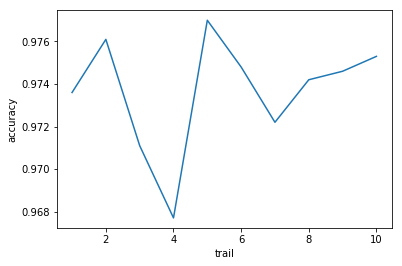

In [370]:
plt.plot(testing_df['trail'], testing_df['accuracy'])
plt.xlabel('trail')
plt.ylabel('accuracy')